In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import skimage
from matplotlib.colors import hsv_to_rgb
from keras.models import Sequential, load_model
from keras.layers import Convolution2D
from keras.layers import Dense, Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from matplotlib import animation
from IPython.display import display, HTML

Using TensorFlow backend.


In [24]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    h,w = image_current.shape
    hsv = np.zeros((h,w,3)).astype(np.uint8)
    hsv[...,1] = 255
    
    flow = cv2.calcOpticalFlowFarneback(image_current,image_next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    return rgb
def plot_movie(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [28]:
FRAME_PAIR_DELTA_MS = 300
IMG_HEIGHT = 720//4
IMG_WIDTH = 1080//4
TOTAL_TO_PROCESS = 1000

In [2]:
len(glob.glob('val/info/*'))

2500

In [51]:
info_path = info_paths[886]

with open(info_path) as f:
        info = json.load(f)
info_df = pd.DataFrame(info['locations'])

In [2]:
y = pd.read_csv('data/info.csv')

In [20]:
X = []
for index, row in y.iterrows():
    print(len(y))
    y = y.drop(index)
#     try:
    img = cv2.imread(row['path'])
    X.append(img)#cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA))
#     except:
#         y.drop(index)
    break

26604


In [29]:
# X = []
y = []
info_paths = sorted(glob.glob('data/info/*'))[:TOTAL_TO_PROCESS]
i = 1
for info_path in info_paths:
    print('{}/{}'.format(i, TOTAL_TO_PROCESS))
    vid_path = info_path.replace('info','videos').replace('.json','.mov')
    with open(info_path) as f:
        info = json.load(f)
    info_df = pd.DataFrame(info['locations'])
    info_df['timestamp'] -= min(info_df['timestamp'])
    vid = cv2.VideoCapture(vid_path)
#     print('Reading {}...'.format(vid_path))
    last_idx = len(info_df) - 1
    for index, row in info_df.iterrows():
        if index == 0:
            continue
        timestamp = row['timestamp']
        vid.set(cv2.CAP_PROP_POS_MSEC, timestamp)
        success, frame = vid.read()
        vid.set(cv2.CAP_PROP_POS_MSEC, timestamp + FRAME_PAIR_DELTA_MS)
        next_success, next_frame = vid.read()
        if next_success:
            # generate flow image
            frame = np.rot90(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY),axes=(1,0))
            frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            next_frame = np.rot90(cv2.cvtColor(next_frame,cv2.COLOR_BGR2GRAY),axes=(1,0))
            next_frame = cv2.resize(next_frame, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            flow = opticalFlowDense(frame, next_frame)
            flow_filename = 'data/train/flow/{}_{}.jpg'.format(vid_path.split('/')[-1][:-4],timestamp)
            cv2.imwrite(flow_filename, flow)
            
#             X.append(flow)
            # compute gps delta 
            lat_delta = (info_df.loc[index]['latitude'] - info_df.loc[index-1]['latitude'])*100000
            lon_delta = (info_df.loc[index]['longitude'] - info_df.loc[index-1]['longitude'])*100000
            speed = info_df.loc[index]['speed']
            y.append(np.array((lat_delta, lon_delta, speed)))
    i += 1
pd.DataFrame(y).to_csv('data/train/info.csv', index=False)
print('{} samples processed'.format(len(X)))

1/1000
2/1000
3/1000
4/1000
5/1000
6/1000
7/1000
8/1000
9/1000
10/1000
11/1000
12/1000
13/1000
14/1000
15/1000
16/1000
17/1000
18/1000
19/1000
20/1000
21/1000
22/1000
23/1000
24/1000
25/1000
26/1000
27/1000
28/1000
29/1000
30/1000
31/1000
32/1000
33/1000
34/1000
35/1000
36/1000
37/1000
38/1000
39/1000
40/1000
41/1000
42/1000
43/1000
44/1000
45/1000
46/1000
47/1000
48/1000
49/1000
50/1000
51/1000
52/1000
53/1000
54/1000
55/1000
56/1000
57/1000
58/1000
59/1000
60/1000
61/1000
62/1000
63/1000
64/1000
65/1000
66/1000
67/1000
68/1000
69/1000
70/1000
71/1000
72/1000
73/1000
74/1000
75/1000
76/1000
77/1000
78/1000
79/1000
80/1000
81/1000
82/1000
83/1000
84/1000
85/1000
86/1000
87/1000
88/1000
89/1000
90/1000
91/1000
92/1000
93/1000
94/1000
95/1000
96/1000
97/1000
98/1000
99/1000
100/1000
101/1000
102/1000
103/1000
104/1000
105/1000
106/1000
107/1000
108/1000
109/1000
110/1000
111/1000
112/1000
113/1000
114/1000
115/1000
116/1000
117/1000
118/1000
119/1000
120/1000
121/1000
122/1000
123/1000
1

KeyError: 'timestamp'

In [13]:
preprocessed_path = sorted(glob.glob('data/train/images/*'))
X = []
for img_path in preprocessed_path:
    img = cv2.imread(img_path)
    X.append(img)
y = pd.read_csv('data/train/info.csv')

In [41]:
len(pd.read_csv('data/train/info.csv'))

30942

In [42]:
inputShape = X[0].shape

model = Sequential()
# normalization    
# perform custom normalization before lambda layer in network
model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))
model.add(Convolution2D(24, (5, 5), 
                        strides=(2,2), 
                        padding = 'valid',
                        kernel_initializer = 'he_normal',
                        name = 'conv1'))
model.add(ELU())    
model.add(Convolution2D(36, (5, 5), 
                        strides=(2,2), 
                        padding = 'valid',
                        kernel_initializer = 'he_normal',
                        name = 'conv2'))
model.add(ELU())    
model.add(Convolution2D(48, (5, 5), 
                        strides=(2,2), 
                        padding = 'valid',
                        kernel_initializer = 'he_normal',
                        name = 'conv3'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Convolution2D(64, (3, 3), 
                        strides = (1,1), 
                        padding = 'valid',
                        kernel_initializer = 'he_normal',
                        name = 'conv4'))
model.add(ELU())              
model.add(Convolution2D(64, (3, 3), 
                        strides= (1,1), 
                        padding = 'valid',
                        kernel_initializer = 'he_normal',
                        name = 'conv5'))
model.add(Flatten(name = 'flatten'))
model.add(ELU())
model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
model.add(ELU())
model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
model.add(ELU())
model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
model.add(ELU())
# do not put activation at the end because we want to exact output, not a class identifier
model.add(Dense(3, name = 'output', kernel_initializer = 'he_normal'))
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=5, padding="same",input_shape=X[0].shape, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=3, padding="same", activation = 'relu'))
model.add(Conv2D(128, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=3, padding="valid", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'  ))
model.add(Dropout(0.1))
model.add(Dense(units=50, activation='relu'  ))
model.add(Dropout(0.1))
model.add(Dense(units=10, activation='relu'  ))
model.add(Dropout(0.3))
model.add(Dense(3, name = 'output'))
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [35]:
X_train, X_val, y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.33, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [7095, 30942]

In [46]:
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100, verbose = 1, batch_size=1)

Train on 4753 samples, validate on 2342 samples
Epoch 1/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1922 - val_loss: 8.9553
Epoch 2/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1588 - val_loss: 8.7314
Epoch 3/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1922 - val_loss: 8.7436
Epoch 4/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1782 - val_loss: 8.9038
Epoch 5/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1669 - val_loss: 8.7169
Epoch 6/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1841 - val_loss: 8.7640
Epoch 7/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1668 - val_loss: 8.6771
Epoch 8/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1688 - val_loss: 8.6777
Epoch 9/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1733 - val_loss: 8.7163
Epoch 1

Epoch 78/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.0804 - val_loss: 9.0385
Epoch 79/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.0844 - val_loss: 8.7965
Epoch 80/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.0857 - val_loss: 8.7222
Epoch 81/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.0710 - val_loss: 8.7035
Epoch 82/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.1525 - val_loss: 8.9047
Epoch 83/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.0828 - val_loss: 8.7956
Epoch 84/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.0599 - val_loss: 8.7818
Epoch 85/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.0797 - val_loss: 8.6938
Epoch 86/100
4753/4753 [==============================] - 59s 12ms/step - loss: 0.0840 - val_loss: 8.8102
Epoch 87/100
4753/4753 [======================

In [44]:
model.save('nvidia.h5')

No handles with labels found to put in legend.


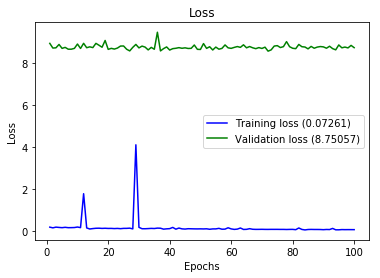

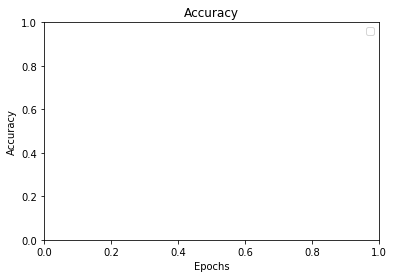

In [47]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_history(history)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 180, 270, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 88, 133, 24)       1824      
_________________________________________________________________
elu_17 (ELU)                 (None, 88, 133, 24)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 42, 65, 36)        21636     
_________________________________________________________________
elu_18 (ELU)                 (None, 42, 65, 36)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 19, 31, 48)        43248     
_________________________________________________________________
elu_19 (ELU)                 (None, 19, 31, 48)        0         
__________

In [5]:
model = load_model('model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
preds = model.predict(np.array(X_train[:10]))

In [9]:
pd.DataFrame(preds)

,0,1,2
0,0.000069,-0.006464,0.354181
1,0.000059,-0.005117,0.042577
2,-0.000647,0.011007,17.231133
3,0.000773,-0.010612,15.794473
4,0.000154,-0.005034,2.012941
5,-0.000497,0.007279,20.340448
6,0.000059,-0.005117,0.042579
7,0.000059,-0.005118,0.042588
8,0.001191,-0.015986,12.352467
9,0.000104,-0.003252,23.333912


In [12]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.DataFrame(y_train[:10])

,0,1,2
0,0.000003,0.000007,0.480000
1,-0.000004,-0.000115,8.370000
2,-0.000126,-0.000156,19.360001
3,-0.000147,-0.000132,19.469999
4,-0.000003,-0.000006,1.200000
5,-0.000016,0.000202,18.150000
6,0.000015,-0.000014,2.060000
7,0.000000,-0.000000,0.000000
8,-0.000149,0.000030,16.879999
9,-0.000097,0.000246,23.570000
